In [31]:
# load necessary packages
import Pkg; Pkg.add("PrettyTables"); Pkg.add("VegaLite")
using JuMP, GLPK
using Plots; plotly();
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
ENV["COLUMNS"]=120;

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [32]:
gen_info = CSV.read("GeneratorsWithRamp.csv", DataFrame);
fuels = CSV.read("Fuels_dataSmartCities.csv", DataFrame);
loads = CSV.read("Demandfinal.csv", DataFrame);
gen_variable = CSV.read("Generator_variability.csv", DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end

In [33]:
gen_info

,r_id,resource,name,existing_cap_mw,num_units,cap_size,var_om_cost_per_mwh,var_om_cost_per_mwh_in
,Int64,String,String,Float64,Int64,Float64,Int64,Int64
1,1,WT,Steel Winds Wind Farm,20.0,1,20.0,0,0
2,2,WT,Steel Winds II,15.0,1,15.0,0,0
3,3,PV,Steel Sun 2 2303-III-2 Hamburg Tpke,2.0,1,2.0,0,0
4,4,PV,Steel Sun 2 2303-III-4 Hamburg Tpke,2.0,1,2.0,0,0
5,5,PV,Steel Sun 2 2303-III-9 Hamburg Tpke,2.0,1,2.0,0,0
6,6,WT,High Sheldon,112.5,1,112.5,0,0
7,7,CC,Fossil-Fuel Generation,2000.0,1,2000.0,3,0
8,8,BM,"Covanta Niagara I, LLC",36.0,1,36.0,0,0
9,9,HY,Hydraulic Race,2.8,1,2.8,0,0


In [34]:
# Keep only the columns relevant to our ED model 
# (We'll come back to other columns in our unit commitment notebooks)
select!(gen_info, 1:12) # columns 1:10 and cluster IDs
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false
gen_df = gen_df[1:25,:]
gen_df[in(["WT","PV","HY"]).(gen_df.resource),:is_variable] .= true;

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.resource);

In [35]:
gen_df

,r_id,resource,name,existing_cap_mw,num_units,cap_size,var_om_cost_per_mwh,var_om_cost_per_mwh_in
,Int64?,String?,String?,Float64?,Int64?,Float64?,Int64?,Int64?
1,1,WT,Steel Winds Wind Farm,20.0,1,20.0,0,0
2,2,WT,Steel Winds II,15.0,1,15.0,0,0
3,3,PV,Steel Sun 2 2303-III-2 Hamburg Tpke,2.0,1,2.0,0,0
4,4,PV,Steel Sun 2 2303-III-4 Hamburg Tpke,2.0,1,2.0,0,0
5,5,PV,Steel Sun 2 2303-III-9 Hamburg Tpke,2.0,1,2.0,0,0
6,6,WT,High Sheldon,112.5,1,112.5,0,0
7,7,CC,Fossil-Fuel Generation,2000.0,1,2000.0,3,0
8,8,BM,"Covanta Niagara I, LLC",36.0,1,36.0,0,0
9,9,HY,Hydraulic Race,2.8,1,2.8,0,0


In [36]:
CSV.write("gen_df.csv",gen_df)

"gen_df.csv"

In [37]:
gen_variable_long = stack(gen_variable, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);

In [38]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi(gen_df, loads, gen_variable)
    ED = Model(GLPK.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # time periods used for ramp constraints
    
    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Ramp up constraints
    @constraint(ED, RampUp[i in G, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    # Ramp down constraints
    @constraint(ED, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )
    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    # This requires a few extra steps because we are indexing decision variables over two sets: generator and time
    solution = DataFrame(value.(GEN).data)
    ax1 = value.(GEN).axes[1]
    ax2 = value.(GEN).axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    
    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        status = termination_status(ED)
    )

end

economic_dispatch_multi (generic function with 1 method)

In [39]:
#solve a week's economic dispatch

T_period = (1):(168)

loads = loads[in.(loads.hour,Ref(T_period)),:]
gen_variable = gen_variable_long[in.(gen_variable_long.hour,Ref(T_period)),:]

,hour,gen_full,cf
,Int64,String,Float64
1,1,pv,0.0
2,2,pv,0.0
3,3,pv,0.0
4,4,pv,0.0
5,5,pv,0.0
6,6,pv,0.0
7,7,pv,0.035
8,8,pv,0.123
9,9,pv,0.301


In [40]:
solution = economic_dispatch_multi(gen_df, loads, gen_variable);

In [41]:
sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen, [:hour, :resource])
#CSV.write("sol_gen_btm.csv",sol_gen_march)

,resource,hour,gen_sum
,String?,Int64,Float64
1,BM,1,0.0
2,CC,1,819.676
3,HY,1,281.794
4,PS,1,240.0
5,PV,1,0.0
6,WT,1,27.63
7,BM,2,0.0
8,CC,2,775.586
9,HY,2,281.794


In [42]:
sol_gen_sum = combine(groupby(sol_gen, [:resource]), :gen_sum => sum)

,resource,gen_sum_sum
,String?,Float64
1,BM,0.0
2,CC,1.5059e5
3,HY,62583.8
4,PS,40320.0
5,PV,766.751
6,WT,8797.39


In [43]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 

263058.0999999998

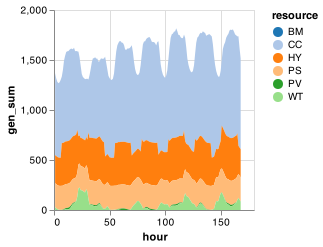

In [44]:
sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

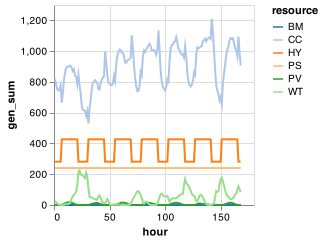

In [45]:
sol_gen |>
@vlplot(:line, 
    x=:hour, y=:gen_sum, 
    color={"resource:n", scale={scheme="category20"}})